# BAYESIAN MODEL

In [2]:
import pandas as pd
import numpy as np
from pandas import Series, DataFrame

from numpy.random import randn
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sb

import theano.tensor as tt


import cPickle
import gzip
import math
import os
from shutil import copyfile
from datetime import datetime

# turn off some pandas warnings
pd.options.mode.chained_assignment = None  # default='warn'

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.


In [3]:
# plot styles
plt.style.use('seaborn-whitegrid')
rcParams['figure.figsize'] = 20, 9
sb.set_style('whitegrid')

In [4]:
import pymc3 as pm
from datetime import datetime
from sklearn.preprocessing import LabelEncoder
import scipy.stats as stats
from PIL import Image

In [23]:
cc_data =pd.read_excel('C:/Users/darog/Desktop/final_file.xlsx')
cc_data.head()

,car_id,carDriveTrain,carEngine,makeName,modelName,trimName,transmissionName,modelYear,carVendor,miles,price,carLocation
0,73531922,FWD,1.8 4 Cylinder Sequential-Port F.I.,Toyota,Corolla,LE,A,2015,Chantilly,23036,13298,VA 20151
1,72354903,4WD,3.6L 6 CYL. GAS,Jeep,Wrangler,Unlimted Sahara,A,2012,Baltimore,73619,26995,MD 21215
2,73704666,FWD,1.80L I4,Honda,Civic,LX,A,2014,Ellicott City,27784,14097,MD 21043
3,73566743,4WD,3.6L V6 Flex Fuel 24V VVT,Jeep,Grand Cherokee,Limited,8-Speed A,2014,Palmyra,36636,27899,PA 17078
4,73745994,AWD,2.40L I4,Hyundai,Santa Fe,Sport 24L,A,2013,Doylestown,48568,18981,PA 18902


In [6]:
cc_data.reset_index(inplace=True,drop=True)
cc_data.shape

(21142, 12)

In [7]:
# modelYear to int
cc_data.modelYear = cc_data.modelYear.astype('int')

In [8]:
#Look at the range for price and miles. Both have a very large spread. This is not suprising given the mix of vehicle listings
#compiled- from daily driven work trucks to high-end exotics. The price/miles relationships will be further explored in EDA.

In [9]:
cc_data[['price','miles']].describe().T

,count,mean,std,min,25%,50%,75%,max
price,21142.0,21825.987135,12908.545505,700.0,13980.00,18925.0,26565.0,139981.0
miles,21142.0,43211.953079,32658.365773,1003.0,21491.25,34698.5,54122.5,218950.0


In [10]:
#First question, how many years, makes, models and trim leves are in the dataset?

In [11]:
print 'Number of unique years is %s' % len(cc_data.modelYear.unique())
print 'Number of unique makes is %s' % len(cc_data.makeName.unique())
print 'Number of unique models is %s' % len(cc_data.modelName.unique())
print 'Number of unique trim levels is %s' % len(cc_data.trimName.unique())

Number of unique years is 18
Number of unique makes is 51
Number of unique models is 685
Number of unique trim levels is 1131


In [12]:
# reset index so functions don't complain later 
cc_data.reset_index(inplace=True,drop=True)

In [27]:
def ymmt_cc(df):

    # making all of these string, as some are numeric
    year = str(df.modelYear)
    make = str(df.makeName)
    model = str(df.modelName)
    # deal with case of no trim level
    if df.trimName != None:
        trim = str(df.trimName)
    else:
        trim = ''
    ymmt = ' '.join([year,make,model,trim])
    return ymmt
    
cc_data['ymmt'] = cc_data.apply(ymmt_cc,axis=1)
cc_data['ymmt'].head()

0               2015 Toyota Corolla LE    
1    2012 Jeep Wrangler Unlimted Sahara   
2                  2014 Honda Civic LX    
3    2014 Jeep Grand Cherokee   Limited   
4      2013 Hyundai Santa Fe   Sport 24L  
Name: ymmt, dtype: object

In [14]:
#Functions for loading and saving gzipped pickle files

In [15]:
def load_zipped_pickle(filename):
    with gzip.open(filename, 'rb') as f:
        loaded_object = cPickle.load(f)
        return loaded_object

def save_zipped_pickle(obj, filename, protocol=-1):
    with gzip.open(filename, 'wb') as f:
        cPickle.dump(obj, f, protocol)

In [16]:
#Reset the index and save results for use in the modeling steps

In [17]:
cc_data.reset_index(inplace=True,drop=True)

cc_file = '/Users/darog/Desktop/Capstone/clean_data/cc_data_clean.pgz'

save_zipped_pickle(cc_data,cc_file)

##### Bayesian Linear Regression

In [18]:
#Due to the size of the dataset and amount of time it takes to run the Bayes processing, we will limit the data here to a single
#make for use with model code shown below.

In [19]:
#cc_data.head()

,car_id,carDriveTrain,carEngine,makeName,modelName,trimName,transmissionName,modelYear,carVendor,miles,price,carLocation,ymmt
0,73531922,FWD,1.8 4 Cylinder Sequential-Port F.I.,Toyota,Corolla,LE,A,2015,Chantilly,23036,13298,VA 20151,2015 Toyota Corolla LE
1,72354903,4WD,3.6L 6 CYL. GAS,Jeep,Wrangler,Unlimted Sahara,A,2012,Baltimore,73619,26995,MD 21215,2012 Jeep Wrangler Unlimted Sahara
2,73704666,FWD,1.80L I4,Honda,Civic,LX,A,2014,Ellicott City,27784,14097,MD 21043,2014 Honda Civic LX
3,73566743,4WD,3.6L V6 Flex Fuel 24V VVT,Jeep,Grand Cherokee,Limited,8-Speed A,2014,Palmyra,36636,27899,PA 17078,2014 Jeep Grand Cherokee Limited
4,73745994,AWD,2.40L I4,Hyundai,Santa Fe,Sport 24L,A,2013,Doylestown,48568,18981,PA 18902,2013 Hyundai Santa Fe Sport 24L


In [28]:
selected_data = cc_data[(cc_data.makeName =="Ford") & (cc_data.ymmt =="2014 Ford Escape SE") & (cc_data.modelName =="Escape") & (cc_data.trimName =="SE") & (cc_data.modelYear == 2014)]
selected_data.head()

,car_id,carDriveTrain,carEngine,makeName,modelName,trimName,transmissionName,modelYear,carVendor,miles,price,carLocation,ymmt
30,72412728,AWD,1.60L I4,Ford,Escape,SE,A,2014,King Of Prussia,42694,16998,PA 19406,2014 Ford Escape SE
45,73619027,FWD,1.60L I4,Ford,Escape,SE,A,2014,King Of Prussia,31246,15998,PA 19406,2014 Ford Escape SE
151,73069500,AWD,EcoBoost 1.6L I4 GTDi DOHC Turbocharged VCT,Ford,Escape,SE,6-Speed A,2014,Cherry Hill,19581,18998,NJ 08034,2014 Ford Escape SE
249,73713822,AWD,2.0 4 Cylinder Turbocharged,Ford,Escape,SE,Shiftable A,2014,Lititz,31482,18991,PA 17543,2014 Ford Escape SE
357,72752814,4WD,1.6 liter Turbocharged I4,Ford,Escape,SE,6-Speed Shiftable A,2014,Dillsburg,94967,12995,PA 17019,2014 Ford Escape SE


In [29]:
make_names = cc_data.makeName.unique()

# number of iterations
niter = 100000

# set make to just Ford for this notebook
make_names = ['Ford']

for make in make_names:
    # dictionaries to store the the traces
    bayes_by_ymm = {}
    bayes_by_model = {}
    # final dataframe
    bayes_make_model_year = pd.DataFrame()

    # keep track of time
    d1 = datetime.now()

    # subset data for just the single make
    cc_data_make = selected_data[cc_data.makeName == make]

    # define the model info for each make
    model_coder = LabelEncoder()
    cc_data_make['model_code'] = model_coder.fit_transform(cc_data_make.modelName)
    model_codes = cc_data_make.model_code.unique()
    model_codes_idx = cc_data_make.model_code.values
    num_model_codes = len(model_codes)
    model_names = cc_data_make.modelName.unique()

    #for model in model_names:
    for mdl,mdl_i in enumerate(model_codes[0:1]):
        model = str(model_coder.inverse_transform(mdl))
        bayes_by_year = {}

        #further subset the data
        cc_data_model = cc_data_make[cc_data_make.modelName == model]

        # define the year info for each make
        year_le = LabelEncoder()
        cc_data_model['year_code'] = year_le.fit_transform(cc_data_model.modelYear)
        years = cc_data_model.year_code.unique()
        year_codes_idx = cc_data_model.year_code.values
        num_years = len(cc_data_model.year_code.unique())
        year_codes = cc_data_model.year_code.unique()

        # run for each year of each model
        for yr,yr_1 in enumerate(year_codes[0:1]):

            year = str(year_le.inverse_transform(yr))

            # subset the data again
            cc_data_year = cc_data_model[cc_data_model.modelYear == int(year)]

            # define trims for each make
            trim_coder = LabelEncoder()
            cc_data_year['trim_code'] = trim_coder.fit_transform(cc_data_year.trimName)
            trim_codes = cc_data_year.trim_code.unique()
            trim_codes_idx = cc_data_year.trim_code.values
            num_trims = len(trim_codes)

            print "Now processing %s %s %s with %s trim levels" % (year,make,model,num_trims)
##########################################################################################################################            

##########################################################################################################################            
            with pm.Model() as price_ymm:

                # define the priors and distributions for:

                # intercept priors and distribution: trim

                # set mu for the intercept to the mean price
                # need to do this for cases where there aren't many samples, otherwise
                # the distribution stays centered on zero
                intercept_mu = cc_data_year.price.mean()

                intercept_trim_mean = pm.Normal('intercept_trim_mean', mu=intercept_mu, sd=10000.)
                intercept_trim_sd = pm.Normal('intercept_trim_sd',mu=intercept_mu, sd=10000.)
                intercept_trim_overall = pm.Normal('intercept_trim_overall',
                                            mu=intercept_trim_mean, sd=intercept_trim_sd, shape=num_trims)

                # miles priors: trim
                miles_trim_mean = pm.Normal('miles_trim_mean', mu=0, sd=10000.)
                miles_trim_sd = pm.Gamma('miles_trim_sd', mu=0.0001, sd=10000.)
                # miles distribuitions
                miles_trim_overall = pm.Normal('miles_trim_overall',mu=miles_trim_mean,
                                          sd=miles_trim_sd, shape=num_trims)

                # regression formula
                price_est = (intercept_trim_overall[trim_codes_idx] +
                             miles_trim_overall[trim_codes_idx]*cc_data_year.miles.values)

                # model error
                model_error = pm.Uniform('model_error', lower=0, upper=100000)

                # calculate likelihood
                price_like = pm.Normal('price_like', mu=price_est, sd=model_error, observed=cc_data_year.price.values)

                step = pm.Metropolis()

                # run
                trace = pm.sample(niter,step=step)

                print '\n'
                
############################################################################################################################

 # don't keep all the traces
                bayes_by_year[year] = trace[niter/2:]

            # outside the Bayes model now
            # create and populate the dataframe
            # define lists that will be used when creating the new dataframe
            yr_names = []
            yr_codes = []
            mk_names = []
            mdl_names = []
            mdl_codes = []
            trm_names = []
            trm_codes = []
            ymmts = []
            prob_dists = []

            # go through each trim level
            for trm,trm_i in enumerate(trim_codes):

                # now get the year, model, trim values back from using the inverse encoder
                yr_e = year_le.inverse_transform(yr)
                mdl_e = str(model_coder.inverse_transform(mdl))
                # check if trim has a value or not
                if trim_coder.inverse_transform(trm) != None:
                    trm_e = str(trim_coder.inverse_transform(trm))
                else:
                    trm_e = ''

                # create ymmt value
                ymmt = ' '.join([str(yr_e),make,mdl_e,trm_e])

                # if the ymmt isn't in the parent set, then it doesn't
                # need to be in the final df
                if len(selected_data[selected_data.ymmt == ymmt]) > 0:

                    # fill lists that will be used when creating the new dataframe
                    ymmts.append(ymmt)
                    yr_names.append(yr_e)
                    yr_codes.append(yr)
                    mk_names.append(make)
                    mdl_names.append(mdl_e)
                    mdl_codes.append(mdl)
                    trm_names.append(trm_e)
                    trm_codes.append(trm)

                    # get the price probability dist for each ymmt from the bayes files
                    prob =      (bayes_by_year[year]['intercept_trim_overall'][:,trm] +
                                 bayes_by_year[year]['miles_trim_overall'][:,trm])

                    prob_dists.append(prob)

                else:
                    pass

            # put it all in a dataframe
            year_df = pd.DataFrame({
                    'ymmt':ymmts,
                    'makeName':mk_names,
                    'modelYear':yr_names,
                    'year_code':yr_codes,
                    'modelName':mdl_names,
                    'model_code':mdl_codes,
                    'trimName':trm_names,
                    'trim_code':trm_codes,
                    'prob_dists':prob_dists
                })

            # update the dataframe
            bayes_make_model_year = pd.concat((bayes_make_model_year,year_df))

            # save traces with model
            bayes_by_model[model] = bayes_by_year

        # save traces by make
        bayes_by_ymm[make] = bayes_by_model
        #print bayes_by_ymm[make].keys()

    # reset the df index before saving
    bayes_make_model_year.reset_index(inplace=True,drop=True)
    # directory for saving the files
    #file_dir = '/home/ubuntu/bayes/'
    file_dir = '/Users/darog/Desktop/Capstone/clean_data/bayes'

#########################################################################################################################

    # save the dataframe
    df_file = file_dir+str(make)+'_df.pgz'
    #save_zipped_pickle(bayes_make_model_year,df_file)

    # file name for the traces
    trace_file = file_dir +str(make)+'_bayes.pgz'
    # save the traces
    # pickle the traces to save the output
    #save_zipped_pickle(bayes_by_ymm,trace_file)

    d2 = datetime.now()
    time_diff = int((d2-d1).total_seconds() / 60)
    print '\nWrote:\n%s and \n%s\nTotal processing time for %s: %s minutes\n' % (trace_file,df_file,make,time_diff)
    




C:\Users\darog\Anaconda2\lib\site-packages\ipykernel\__main__.py:20: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Now processing 2014 Ford Escape with 1 trim levels


100%|██████████████████████████████████████████████████████████████████████████| 100500/100500 [21:42<00:00, 77.17it/s]





Wrote:
/Users/darog/Desktop/Capstone/clean_data/bayesFord_bayes.pgz and 
/Users/darog/Desktop/Capstone/clean_data/bayesFord_df.pgz
Total processing time for Ford: 21 minutes



In [30]:
#Content of dictionary that is storing the traces from the price_ymm pymc3 model:
print bayes_by_ymm.keys()
print bayes_by_ymm['Ford'].keys()
print bayes_by_ymm['Ford']['Escape'].keys()

['Ford']
['Escape']
['2014']


In [31]:
#The bayes_make_model_year dataframe contains the ymmt info for using with cc_data, in addition to the price probability 
#distribution.
print bayes_make_model_year.shape
bayes_make_model_year[['ymmt','prob_dists']].head()

(1, 9)


,ymmt,prob_dists
0,2014 Ford Escape SE,"[17086.1134753, 17086.1134753, 17086.1134753, ..."


In [32]:
#The resulting trace plot for a single year, make, model is shown below.The plots in the left column are smoothed posterior 
#distributions of the intercept and trim variables. These show the impact that each variable has on the calculation of the 
#posterior prices (i.e., the predictions)
#The right column are the values sampled for each variable during each iteration of the model fitting process. They have reached
#convergence when the lines begin to flatten out. While the job was run for 100000 iterations, only the second half of the 
#traces are shown, as the initial iterations are the 'burn-in' phase where the model is still searching for the optimal 
#parameters.

In [33]:
print 'Number of unique trim levels for 2014 Ford Escape SE:', len(cc_data_year.trimName.unique())

Number of unique trim levels for 2014 Ford Escape SE: 1


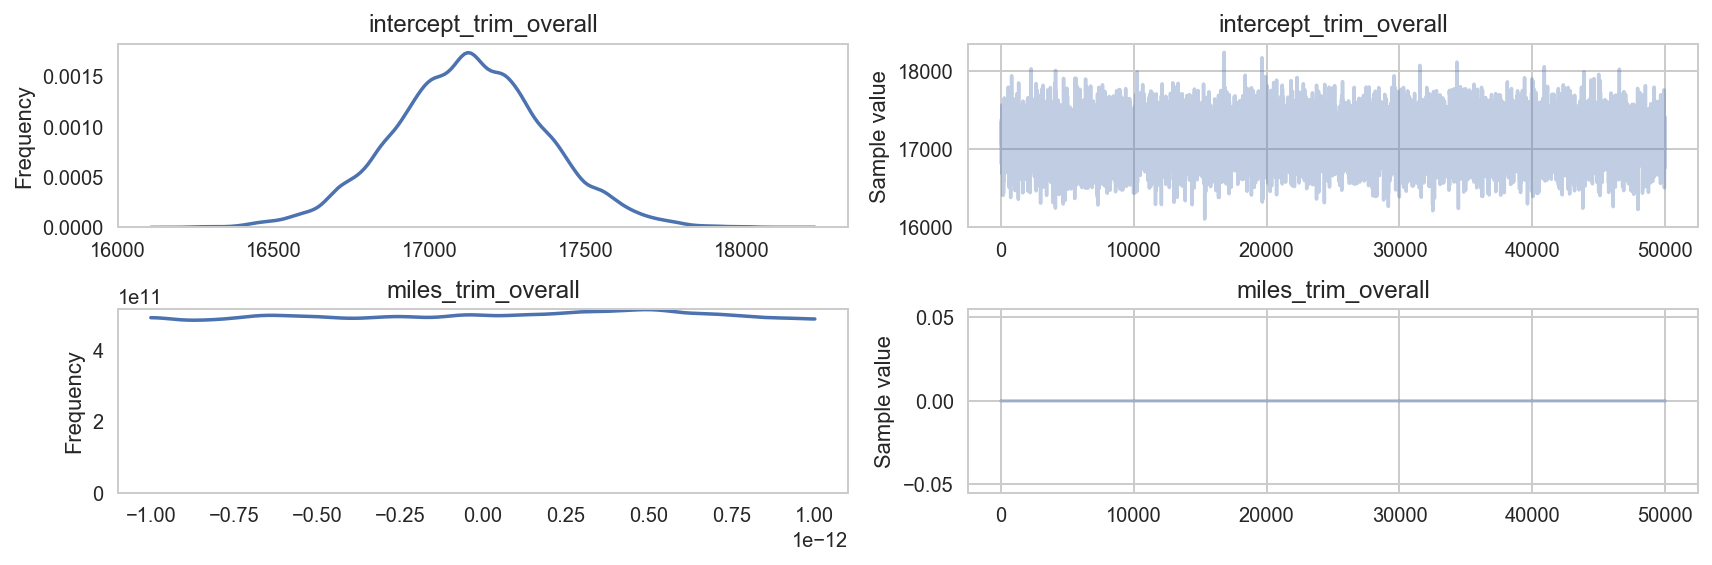

In [34]:
pm.traceplot(bayes_by_ymm['Ford']['Escape']['2014'],varnames=['intercept_trim_overall','miles_trim_overall']);

In [35]:
#In this case, I don't think the model is properly defined, as the results from miles_trim_overall are not reasonable. 
#Despite many effort at tuning the model, I was not able to generate a better fit. One way to check the quality of the model fit
#is to compare the distributions of the predictions and the actual values.

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 666.67it/s]


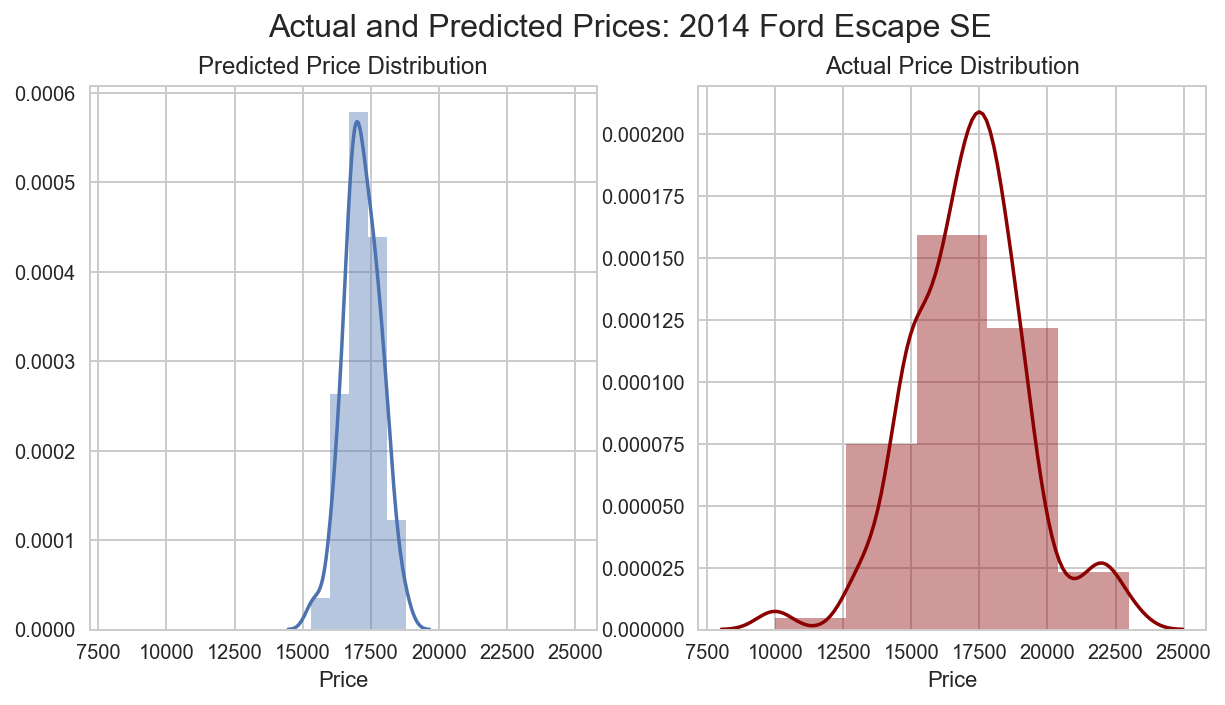

In [38]:
ppc = pm.sample_ppc(bayes_by_ymm['Ford']['Escape']['2014'], model=price_ymm,samples=10)
pred_prices = np.mean(ppc['price_like'],axis=0)

fig, ax = plt.subplots(1,2,figsize=(10,5),sharex=True)

fig.suptitle('Actual and Predicted Prices: 2014 Ford Escape SE',fontsize=16)
# predicted
sb.distplot(pred_prices,ax=ax[0], bins=5)
ax[0].set_title('Predicted Price Distribution')
ax[0].set_xlabel('Price')

# actual
sb.distplot(cc_data_year.price,ax=ax[1], bins=5,color='darkred')
ax[1].set_title('Actual Price Distribution')
ax[1].set_xlabel('Price')

plt.show()

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 555.56it/s]


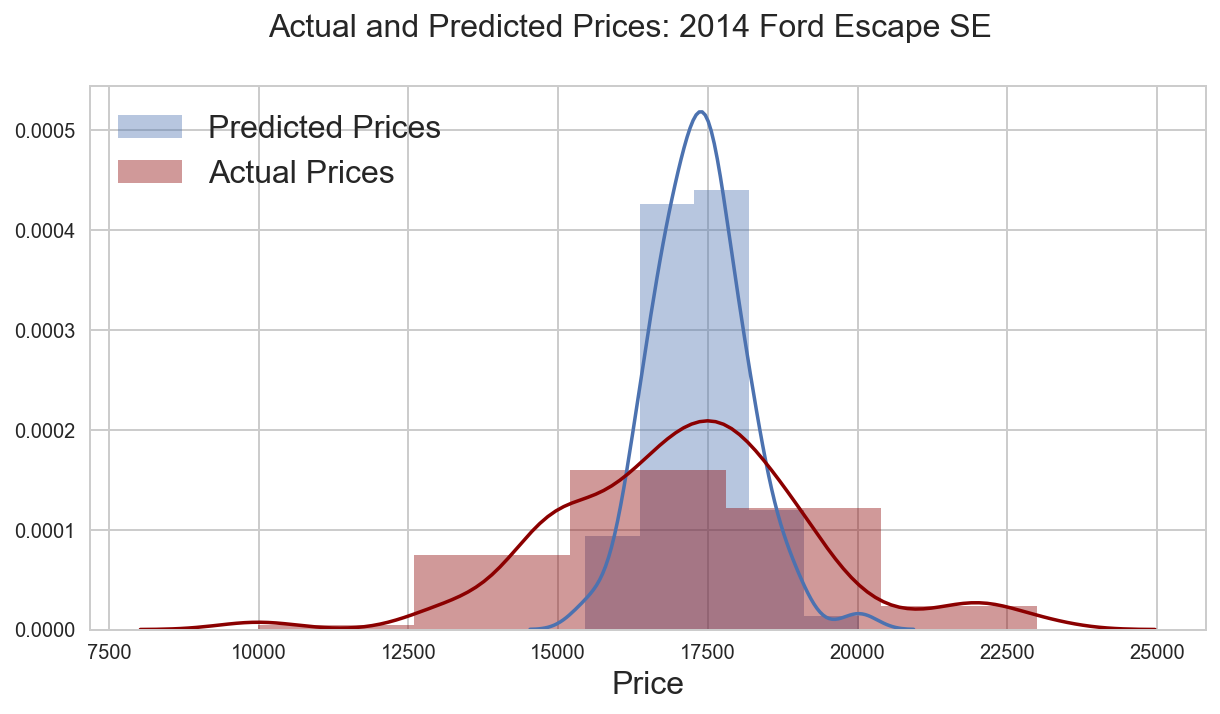

In [39]:
ppc = pm.sample_ppc(bayes_by_ymm['Ford']['Escape']['2014'], model=price_ymm,samples=10)
pred_prices = np.mean(ppc['price_like'],axis=0)

fig,ax = plt.subplots(figsize=(10,5),sharex=True)

fig.suptitle('Actual and Predicted Prices: 2014 Ford Escape SE',fontsize=16)
# predicted
sb.distplot(pred_prices, bins=5,label='Predicted Prices')

# actual
sb.distplot(cc_data_year.price, bins=5,color='darkred',label='Actual Prices')
plt.xlabel('Price',fontsize=16)
plt.legend(loc='upper left',fontsize=16)

plt.show()

In [40]:
#We can also look at the predicted price distribution for a single year, make, model, and trim.
#The plot_posterior function from pymc3 displays the following information:
#a histogram of the price distribution
#the mean value for the distribution
#a bar and text deliminating the range that contains 95% of the predictions

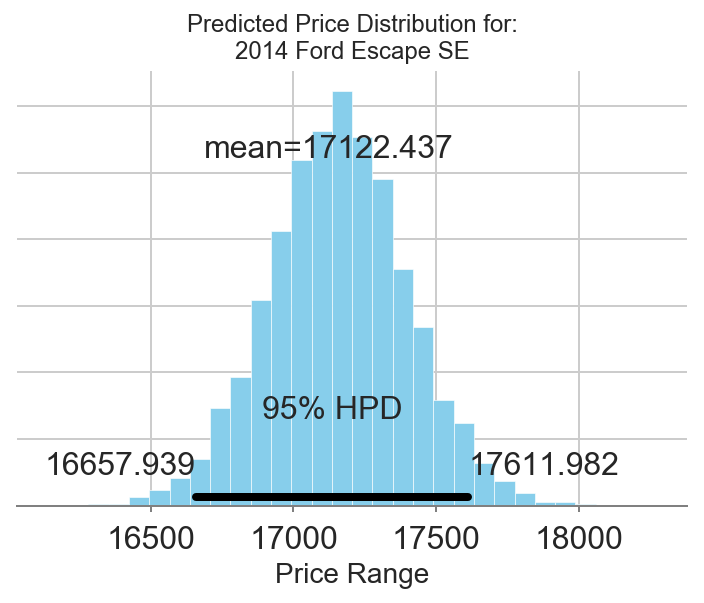

In [41]:
idx = 0
fig = plt.figure(figsize=(6,4))
ax = fig.gca()
pm.plot_posterior(bayes_make_model_year.prob_dists.loc[idx],color='#87ceeb',ax=ax)
plt.title('Predicted Price Distribution for:\n'+bayes_make_model_year.ymmt.loc[idx])
plt.xlabel('Price Range',fontsize=14)
plt.show()

In [ ]:
#Reference: https://github.com/clrife/CarPriceAnalysis/blob/master/CarPriceAnalysis_Technical.ipynb